## Full analysis of waveguide including multimode coupling, overlap integrals, normalization factors, etc.

Let's try a case that is almost single mode.

In [1]:
import lumerical as lum
import numpy as  np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imp
import time
import os
from scipy.integrate import simps
import matplotlib.patches as patches
import matplotlib.cm as cm

from scipy.constants import pi, c, epsilon_0
pm = 1e-12
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
GHz = 1e9
THz = 1e12
pJ = 1e-12
mW = 1e-3

plt.rcParams.update({'font.size': 18})

In [2]:
data_filename = 'Data\LNoI_700nm_340nm_1850nm.npz'
file = np.load(data_filename, allow_pickle=True)
locals().update(file)
freqs = c/wavelength
fstep = freqs[1] - freqs[0]

#Let's trim the data, the initial freqs don't seem to have anything
k1 = 4
print(modes[0:k1,:])

modes = modes[k1:, :]
freqs = freqs[k1:]
wavelength = wavelength[k1:]
loss = loss[k1:, :]
neff = neff[k1:, :]
tepf = tepf[k1:, :]
ng = ng[k1:, :]

[[None None None None None None]
 [None None None None None None]
 [None None None None None None]
 [None None None None None None]]


In [3]:
wavelength/um

array([2.99916949, 2.72641479, 2.49913494, 2.30683239, 2.14200978,
       1.9991696 , 1.87418908, 1.76391574, 1.66589782, 1.57819982,
       1.49927345, 1.42786536, 1.36295014, 1.30368075, 1.24935132,
       1.19936897, 1.15323203, 1.11051316, 1.0708461 , 1.03391508,
       0.99944648, 0.96720195, 0.93697297, 0.90857628, 0.88185018,
       0.85665147, 0.83285286, 0.81034079, 0.78901371, 0.76878043,
       0.74955893, 0.73127515, 0.71386212, 0.69725907, 0.68141078,
       0.66626692, 0.65178155, 0.63791263, 0.62462164, 0.61187318,
       0.5996347 ])

In [4]:
print('Waveguide parameters')
print('thin-film thickness = %0.1f nm' % (h_LN/nm))
print('top witdh = %0.1f nm' % (width_top/nm))
print('etch depth = %0.1f nm' % (h_etch/nm))
print('etch angle = %0.1f degrees' % (theta))

Waveguide parameters
thin-film thickness = 700.0 nm
top witdh = 1850.0 nm
etch depth = 340.0 nm
etch angle = 60.0 degrees


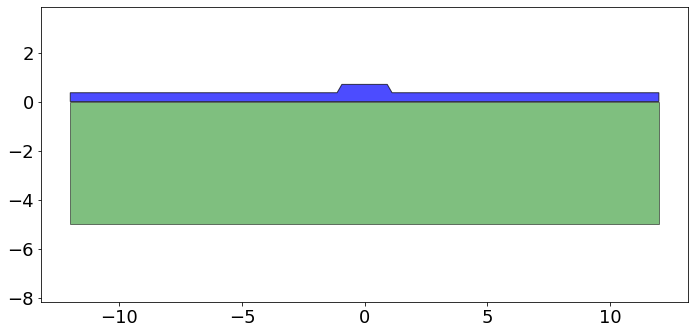

In [5]:
#Draw it
h_slab = h_LN - h_etch
width_top_base = width_top + 2*h_etch/np.tan(theta*pi/180)
w_sidewall = h_etch/np.tan(theta*pi/180)

plt.rcParams['figure.figsize'] = [10, 5]
fig,ax = plt.subplots()
substrate = patches.Rectangle((-w_slab/2/um,-h_substrate/um), w_slab/um, h_substrate/um,
                             linewidth=1, edgecolor='k', facecolor='g', alpha=0.5)
v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                   [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                   [w_slab/2,h_slab], [w_slab/2,0], 
                   [-w_slab/2,0], [-w_slab/2, h_slab] ] )/um
ridge = patches.Polygon(v_ridge, linewidth=1, 
                       edgecolor='k', facecolor='blue', alpha=0.7)

ax.add_patch(substrate)
ax.add_patch(ridge)

plt.axis('equal')
plt.tight_layout()
plt.show()

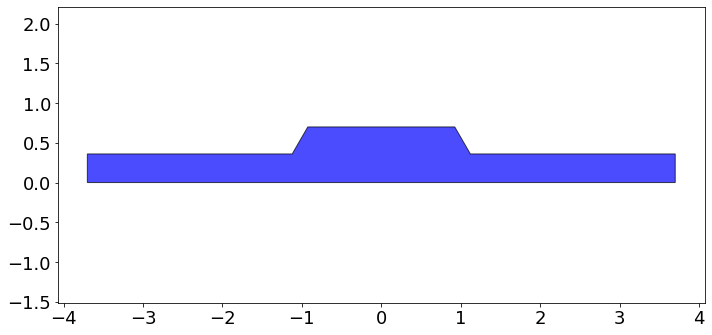

In [6]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,ax = plt.subplots()

v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                   [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                   [2*width_top, h_slab], [2*width_top ,0], 
                   [-2*width_top, 0], [-2*width_top, h_slab] ] )/um
ridge = patches.Polygon(v_ridge, linewidth=1, 
                       edgecolor='k', facecolor='blue', alpha=0.7)

ax.add_patch(ridge)

plt.axis('equal')
plt.tight_layout()
plt.show()

## Let's see some of the data

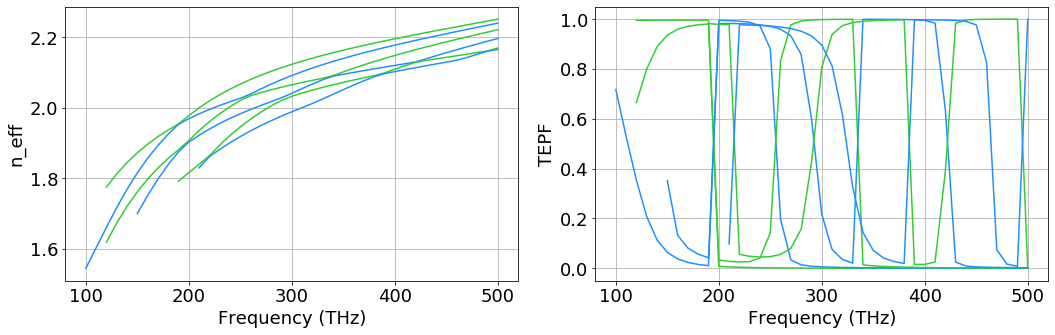

In [7]:
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_prop_cycle(color=['limegreen', 'dodgerblue'])
ax2.set_prop_cycle(color=['limegreen', 'dodgerblue'])
ax1.plot(freqs/THz, neff);
ax2.plot(freqs/THz, tepf);
ax1.grid(True); ax2.grid(True)
ax1.set_xlabel('Frequency (THz)')
ax2.set_xlabel('Frequency (THz)')
ax1.set_ylabel('n_eff')
ax2.set_ylabel('TEPF')
plt.tight_layout()

So, there's a mode crossing around 200 THz. Let's ignore this. Let's assume there's a single mode that is TE and covers over the whole band.

Let's choose that mode.

In this case it is a bit harder to track a single TE mode.

In [8]:
#Go trough tepf array and find mode crossings from TE to TM, store the indexes
tepf_0 = np.zeros_like(freqs)
neff_0 = np.zeros_like(freqs)
mode_te0 = np.empty(freqs.shape, dtype=object)
column_mode_te0 = np.empty(freqs.size)
column_mode_te0[:] = np.nan

tepf_threshold = 0.9
breakpoint = 0
for column in range(tepf.shape[1]):
    for kf in range(freqs.size):
        if tepf[kf, column] > tepf_threshold and kf>=breakpoint:
            tepf_0[kf] = tepf[kf, column]
            neff_0[kf] = neff[kf, column]
            mode_te0[kf] = modes[kf, column]
            column_mode_te0[kf] = column
            breakpoint = kf   
            
neff_0[neff_0 == 0] = np.nan
tepf_0[tepf_0 == 0] = np.nan

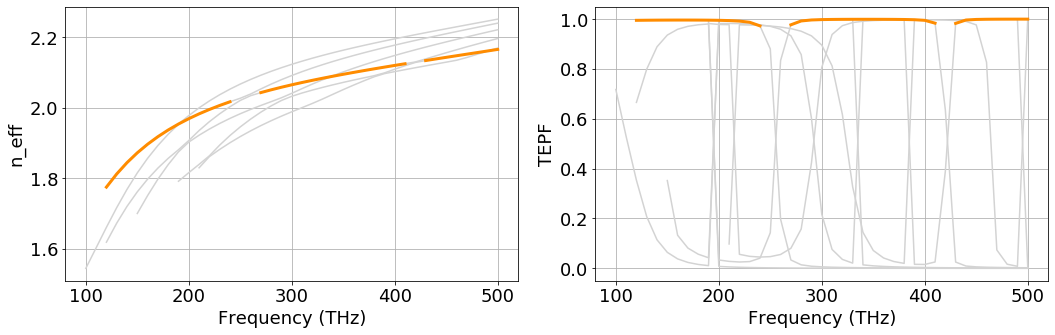

In [9]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(freqs/THz, neff, color='lightgray');
ax1.plot(freqs/THz, neff_0, color='darkorange', linewidth = 3);
ax2.plot(freqs/THz, tepf, color='lightgray');
ax2.plot(freqs/THz, tepf_0, color='darkorange', linewidth = 3);
ax1.grid(True); ax2.grid(True)
ax1.set_xlabel('Frequency (THz)')
ax2.set_xlabel('Frequency (THz)')
ax1.set_ylabel('n_eff')
ax2.set_ylabel('TEPF')
plt.tight_layout()

Let's look at the normalization constant from the modes.

Text(0, 0.5, '$N(\\omega)$')

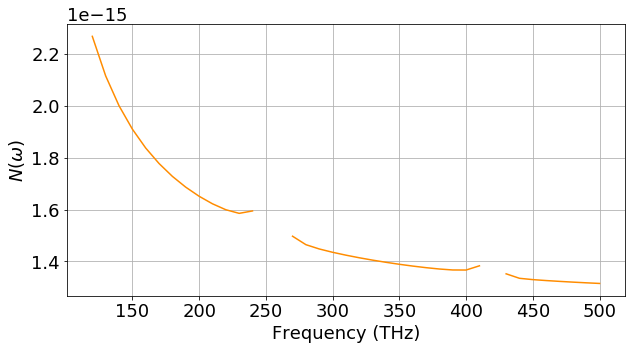

In [10]:
N = np.empty( mode_te0.size )
N[:] = np.nan

for km in range( N.size ):
    if mode_te0[km] != None:
        N[km]  = mode_te0[km].N()
    
plt.rcParams['figure.figsize'] = [10, 5]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(freqs/THz, N, color='darkorange');
ax1.grid(True)
ax1.set_xlabel('Frequency (THz)')
ax1.set_ylabel('$N(\omega)$')

### We can also look at the modes themselves.

In [11]:
x = mode_te0[-1].E.xx
y = mode_te0[-1].E.yy
X, Y = np.meshgrid(x,y)

In [12]:
def plot_mode(F, ax):
    xlim = [-2,2]
    
    #Draw the mode
    im = ax.pcolormesh(X/um, Y/um, (np.transpose(F)), cmap=cm.jet)
    
    #Draw the waveguide
    v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                       [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                       [xlim[1], h_slab], [xlim[1], 0], 
                       [xlim[0], 0], [xlim[0], h_slab] ] )/um
    
    ridge = patches.Polygon(v_ridge, linewidth=1.5, edgecolor='k', alpha=1, fill=False)

    ax.add_patch(ridge)

    #Make Pretty
    ax.set_xlim(xlim)
    ax.set_ylim([-2, 2])
    ax.set_xlabel('X (microns)')
    ax.set_ylabel('Y (microns)')
    
    return im

In [13]:
def create_mask():
    mask = np.transpose(np.real(np.ones_like(mode_te0[-1].E.x)))
    mask[Y> (X+width_top/2+w_sidewall)*np.tan(theta*pi/180)+h_slab] = 0
    mask[Y> (-X+width_top/2+w_sidewall)*np.tan(theta*pi/180)+h_slab] = 0
    mask[Y < h_slab] = 1
    mask[Y>h_LN] = 0
    mask[Y<0] = 0
    return np.transpose(mask)

mask = create_mask()

In [14]:
idx_2um = 9
idx_1um = 24

print(c/freqs[idx_2um]/um)
print(c/freqs[idx_1um]/um)

1.5781998239451172
0.8818501829121541


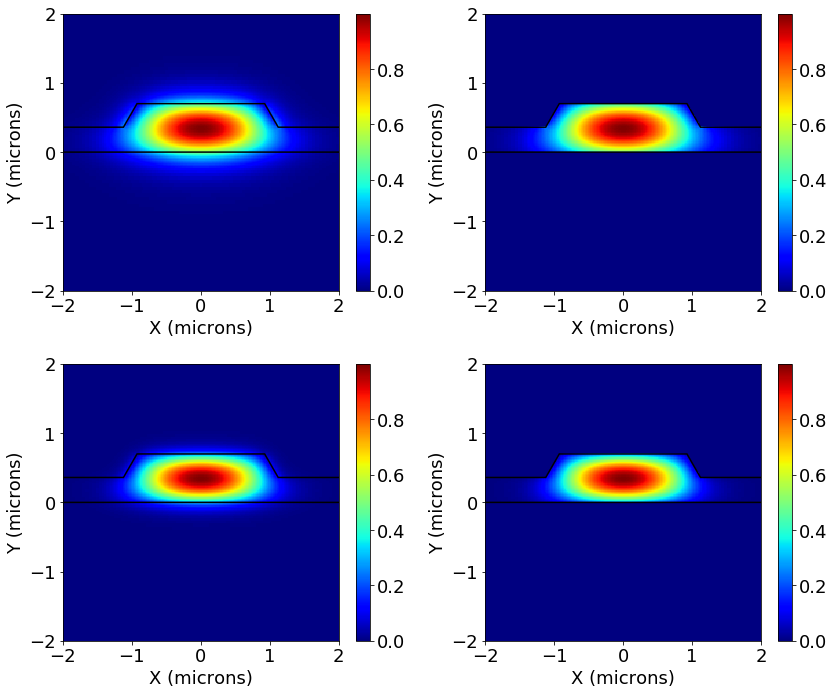

In [15]:
plt.rcParams['figure.figsize'] = [12, 10]

F1 = np.real(mode_te0[idx_2um].E.x)
F2 = np.real(mode_te0[idx_2um].E.x * mask)
F3 = np.real(mode_te0[idx_1um].E.x)
F4 = np.real(mode_te0[idx_1um].E.x * mask)

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

im1 = plot_mode(F1, ax1)
im2 = plot_mode(F2, ax2)
im3 = plot_mode(F3, ax3)
im4 = plot_mode(F4, ax4)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
fig.colorbar(im4, ax=ax4)

plt.tight_layout()

## Nonlinear Polarization

Let's start with the nonlinear susceptibility tensor.

In [16]:
d31 = -4.6*pm
d22 = 2.2*pm
d33 = -25*pm

chi2 = np.zeros([3,3,3])
chi2[2,2,2] = 2*d33
chi2[([0,0,1,1,2,2], [2,0,1,2,0,1], [0,2,2,1,0,1])] = 2*d31
chi2[([1,1,0,0], [1,0,0,1], [1,0,1,0])] = 2*d22
chi2/pm

array([[[  0. ,   4.4,  -9.2],
        [  4.4,   0. ,   0. ],
        [ -9.2,   0. ,   0. ]],

       [[  4.4,   0. ,   0. ],
        [  0. ,   4.4,  -9.2],
        [  0. ,  -9.2,   0. ]],

       [[ -9.2,   0. ,   0. ],
        [  0. ,  -9.2,   0. ],
        [  0. ,   0. , -50. ]]])

We need to permute the axes of the fields to match the crystal labels, so x->z, y->x, z->y

In [17]:
def permute_axes(A):
    Bx = A.y
    By = A.z
    Bz = A.x
    return lum.field_2D(A.xx, A.yy, Bx, By, Bz)

In [18]:
def polarization(E1, E2):
    '''
    Input fields should be on crystal axes frame
    '''
    Px = np.zeros_like(E1.x)
    Py = np.zeros_like(E1.x)
    Pz = np.zeros_like(E1.x)
    
    Ea = np.array([E1.x, E1.y, E1.z])
    Eb = np.array([E2.x, E2.y, E2.z])
    
    for kj in range(3):
        for kz in range(3):
            Px = Px + chi2[0, kj, kz] * Ea[kj] * Eb[kz]
            Py = Py + chi2[1, kj, kz] * Ea[kj] * Eb[kz]
            Pz = Pz + chi2[2, kj, kz] * Ea[kj] * Eb[kz]
    
    Px = epsilon_0 * Px * mask
    Py = epsilon_0 * Py * mask
    Pz = epsilon_0 * Pz * mask
    
    P = lum.field_2D(E1.xx, E1.yy, Px, Py, Pz)
    return P

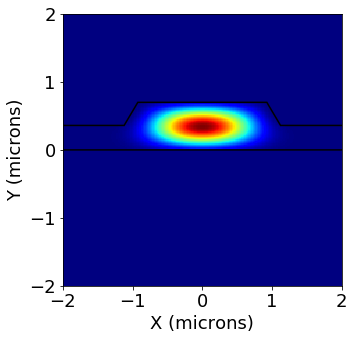

In [19]:
E1 = permute_axes(mode_te0[idx_1um].E)
E2 = permute_axes(mode_te0[idx_1um].E)
P = polarization(E1, E2)
F = np.abs(P.z)

plt.rcParams['figure.figsize'] = [5, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)
plot_mode(F, ax1)

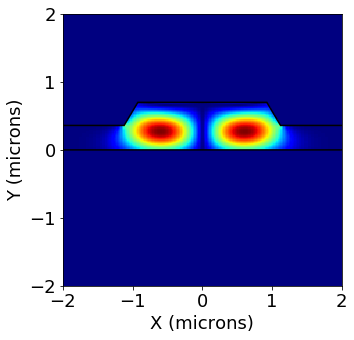

In [20]:
E1 = permute_axes(modes[idx_2um, 0].E)
E2 = permute_axes(modes[idx_2um, 1].E)
P = polarization(E1, E2)
F = np.abs(P.z)

plt.rcParams['figure.figsize'] = [5, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)
plot_mode(F, ax1)

## Overlap Integral

In [21]:
def X_func(Ea, Eb, Ec):
    '''
    Input fields are in Lumerical coordinate frame (not crystal frame)
    '''
    
    #Need to map lumerical coordinate system to crystal axes
    E1 = permute_axes(Ea)
    E2 = permute_axes(Eb)
    E3 = permute_axes(Ec)
    
    P = polarization(E2,E3)
    integrand = P.dot(E1.conj())

    x = P.xx
    y = P.yy
    
    return simps(simps(integrand, y), x)

In [22]:
def get_X_array(Nnew):
    '''This gets the 2D X array given a normalization vector N vs frequency'''
    X_array = 1j * np.zeros([freqs.size, freqs.size])
    for k1 in range(wavelength.size):
        for k2 in range(wavelength.size):
            f1 = freqs[k1]
            f2 = freqs[k2]

            k3 = np.argwhere(np.isclose(freqs, np.abs(f1 - f2), atol=fstep/10))
            
            modes_ok = (mode_te0[k1] != None) and (mode_te0[k2] != None) and (mode_te0[k3] != None)
            
            if (k3.size != 0) and modes_ok :
                k3 = k3[0, 0]
                f3 = freqs[k3]

                E1 = mode_te0[k1].E
                E2 = mode_te0[k2].E
                E3 = mode_te0[k3].E

                s1 = np.sqrt(Nnew[k1] / N[k1])
                s2 = np.sqrt(Nnew[k2] / N[k2])
                s3 = np.sqrt(Nnew[k3] / N[k3])
                
                E1 = E1.rescale(s1)
                E2 = E2.rescale(s2)
                E3 = E3.rescale(s3)
                
                if f3<0:
                    E3 = E3.conj()

                X_array[k1, k2] = X_func(E1, E2, E3)

    X_array[X_array == 0] = np.nan
    return X_array

In [23]:
def ratio(X_array):
    r = np.nanmax(np.abs(X_array))/np.nanmin(np.abs(X_array))
    print(r)
    return r

Let's try a linear variation in N

Text(0, 0.5, '$N(\\omega)$')

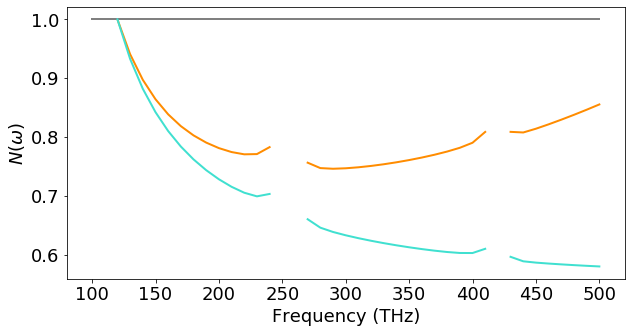

In [24]:
N1 = np.ones_like(freqs)
N_opt = (N/np.nanmax(N)) / np.linspace(1.5, 1, num=freqs.size)

plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(freqs/THz, N_opt/np.nanmax(N_opt), color='darkorange', linewidth=2)
plt.plot(freqs/THz, N1, color='grey', linewidth=2)
plt.plot(freqs/THz, N/np.nanmax(N), color='turquoise', linewidth=2)
plt.xlabel('Frequency (THz)')
plt.ylabel('$N(\omega)$')

In [25]:
# X_array_lumerical = get_X_array(N/np.nanmax(N))
# X_array_normalized = get_X_array(N1)
# X_array_opt = get_X_array(N_opt)

In [26]:
# ratio(X_array_lumerical);
# ratio(X_array_normalized);
# ratio(X_array_opt);

In [27]:
# F1, F2 = np.meshgrid(freqs/THz, freqs/THz)

# plt.rcParams['figure.figsize'] = [8, 5]
# plt.figure()
# plt.pcolormesh(F1, F2, (np.transpose(np.abs(X_array_lumerical))), cmap=cm.jet)
# plt.colorbar()
# plt.grid(True)
# plt.xlabel('$\omega/2\pi $ (THz)')
# plt.ylabel('$\omega^\prime/2\pi$ (THz)')

In [28]:
# plt.figure()
# plt.pcolormesh(F1, F2, (np.transpose(np.abs(X_array_normalized))), cmap=cm.jet)
# plt.colorbar()
# plt.grid(True)
# plt.xlabel('$\omega/2\pi $ (THz)')
# plt.ylabel('$\omega^\prime/2\pi$ (THz)')

In [29]:
# plt.figure()
# plt.pcolormesh(F1, F2, (np.transpose(np.abs(X_array_opt))), cmap=cm.jet)
# plt.colorbar()
# plt.grid(True)
# plt.xlabel('$\omega/2\pi $ (THz)')
# plt.ylabel('$\omega^\prime/2\pi$ (THz)')

## Visual Inspection

In [30]:
def plot_mode(F, ax):
    xlim = [-2,2]
    
    #Draw the mode
    im = ax.pcolormesh(X/um, Y/um, (np.transpose(F)), cmap=cm.jet, vmin=0, vmax=1)
    
    #Draw the waveguide
    v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                       [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                       [xlim[1], h_slab], [xlim[1], 0], 
                       [xlim[0], 0], [xlim[0], h_slab] ] )/um
    
    ridge = patches.Polygon(v_ridge, linewidth=1.5, edgecolor='k', alpha=1, fill=False)

    ax.add_patch(ridge)

    #Make Pretty
    ax.set_xlim(xlim)
    ax.set_ylim([-2, 2])
    ax.set_xlabel('X (microns)')
    ax.set_ylabel('Y (microns)')
    
    return im

def plot_all_components(F):
    plt.rcParams['figure.figsize'] = [16, 4]

    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    im1 = plot_mode(np.abs(F.x), ax1)
    im2 = plot_mode(np.abs(F.y), ax2)
    im3 = plot_mode(np.abs(F.z), ax3)

    fig.colorbar(im1, ax=ax1)
    fig.colorbar(im2, ax=ax2)
    fig.colorbar(im3, ax=ax3)

    plt.tight_layout()

In [60]:
k1 = 5
k2 = 20
f1 = freqs[k1]
f2 = freqs[k2]

k3 = np.argwhere(np.isclose(freqs, np.abs(f1 - f2), atol=fstep/10))
k3 = k3[0, 0]
f3 = freqs[k3]

print(f1/THz)
print(f2/THz)
print((f1-f2)/THz)

149.9584916
299.9584916
-150.0


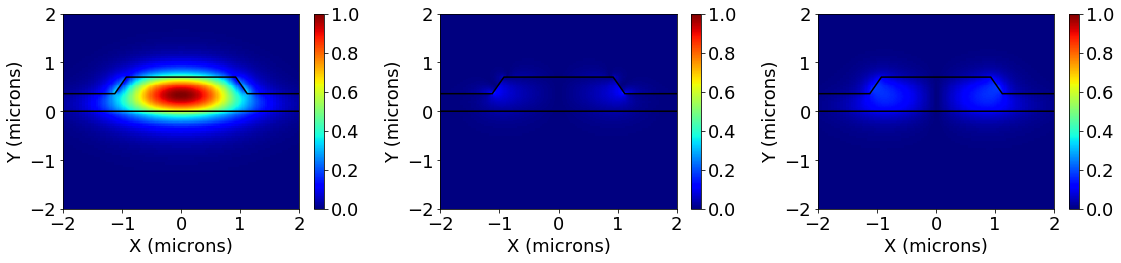

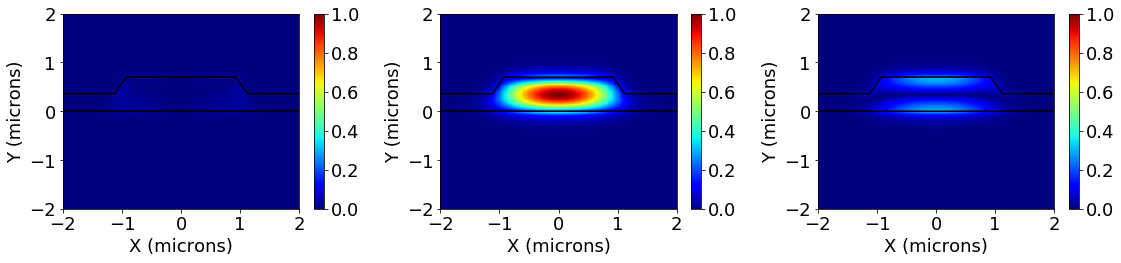

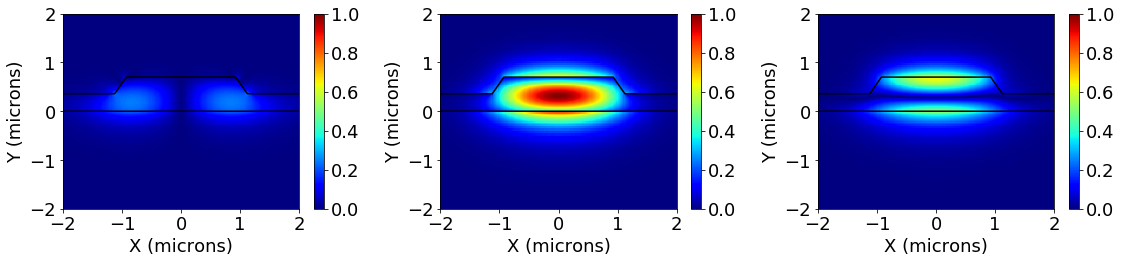

In [97]:
# c1 = int(column_mode_te0[k1])
c1 = 0
# c2 = int(column_mode_te0[k2]) + 3
c2 = 0
# c3 = int(column_mode_te0[k3])
c3 = 1

E1 = modes[k1, c1].E
E2 = modes[k2, c2].E
E3 = modes[k3, c3].E

plot_all_components(E1)
plot_all_components(E2)
plot_all_components(E3)

X =  2.0835051675129492e-13


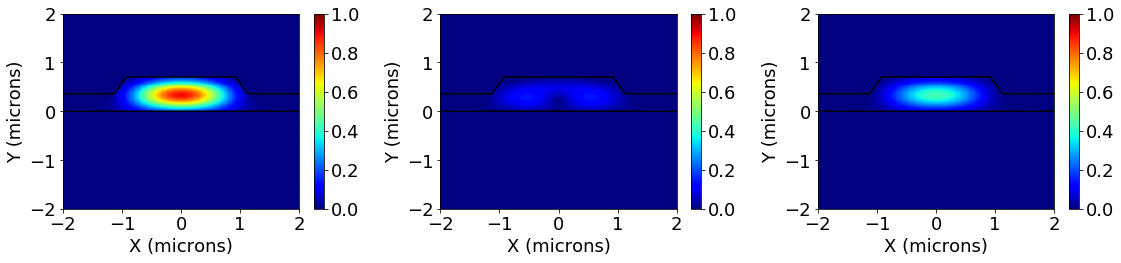

In [98]:
Nnew = N_opt
# Nnew = N

E1 = modes[k1, c1].E
E2 = modes[k2, c2].E
E3 = modes[k3, c3].E

s1 = np.sqrt(Nnew[k1] / N[k1])
s2 = np.sqrt(Nnew[k2] / N[k2])
s3 = np.sqrt(Nnew[k3] / N[k3])

E1 = E1.rescale(s1)
E2 = E2.rescale(s2)
E3 = E3.rescale(s3)

if (f1-f2)<0:
    E3 = E3.conj()

E1 = permute_axes(E1)
E2 = permute_axes(E2)
E3 = permute_axes(E3)

P = polarization(E2,E3)
integrand = P.dot(E1.conj())

print('X = ', np.abs(simps(simps(integrand, P.yy), P.xx) ))

P = permute_axes(permute_axes(P))
plot_all_components(P.rescale(1/np.sqrt(np.amax(P.magsq()))))

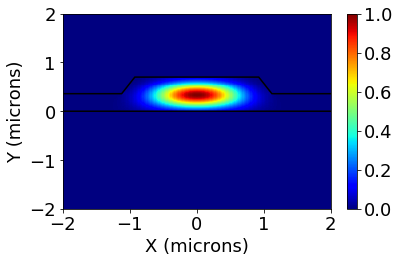

In [99]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
im1 = plot_mode(np.abs(integrand)/np.amax(np.abs(integrand)), ax1)
fig.colorbar(im1, ax=ax1)
plt.tight_layout()